# Breast Cancer Classification using Ultrasound Images
This notebook details a complete deep learning project to classify breast ultrasound images as benign or malignant.

This is a critical task in medical diagnostics, where AI can serve as a powerful "second opinion" to assist radiologists.

## Project Goal
Our objective is to build and compare two different Convolutional Neural Network (CNN) architectures,**ResNet50** and **Inception V3**, to see which provides the best classification performance.

## Workflow
  #### 1. Data Integration:
  * Load and merge two separate ultrasound datasets (BrEaST and BUSI) to create a more robust and larger dataset.

#### 2. Data Preprocessing:

  * Perform a stratified train/validation/test split.

  * Analyze the class distribution and identify a significant class imbalance.

  * Correct the imbalance using oversampling (by augmentation) on the minority class.

  * alculate dataset-specific normalization statistics.

#### 3. Model Training:

  * Fine-tune a pre-trained ResNet50 model.

  * Fine-tune a pre-trained Inception V3 model.

#### 4. Model Evaluation:

  * Evaluate both models on the unseen test set.

  * Compare them using key metrics: Accuracy, F1-Score, Precision, and Recall (Sensitivity).

  * Analyze the Confusion Matrix to understand error types.

# 1.  Setup: Imports, Drive, and Reproducibility


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from albumentations import *


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

from tqdm import tqdm
from albumentations.pytorch import ToTensorV2
import timm
from sklearn.metrics import accuracy_score


In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# 2.  Data Loading & Integration
To build a more robust model, we are combining two separate datasets. We will load each one into a pandas DataFrame, keeping only the image filepaths and their corresponding labels.

## Dataset 1: Breast-Lesions-USG

 [link text](https://www.cancerimagingarchive.net/collection/breast-lesions-usg/)

This dataset uses an Excel file to map image filenames to their clinical data.



In [ ]:
data_dir1 = '/content/drive/My Drive/cancer_proj/BrEaST-Lesions_USG-images_and_masks/BrEaST-Lesions_USG-images_and_masks'
file_path1 = '/content/drive/My Drive/cancer_proj/BrEaST-Lesions_USG-images_and_masks/BrEaST-Lesions-USG-clinical-data-Dec-15-2023.xlsx'


In [ ]:
data1=pd.read_excel(file_path1)
data1 = data1[data1['Classification'] != 'normal']
data1.head()

,CaseID,Image_filename,Mask_tumor_filename,Mask_other_filename,Pixel_size,Age,Tissue_composition,Signs,Symptoms,Shape,...,Echogenicity,Posterior_features,Halo,Calcifications,Skin_thickening,Interpretation,BIRADS,Verification,Diagnosis,Classification
0,1,case001.png,case001_tumor.png,NaN,0.007812,57,heterogeneous: predominantly fat,breast scar,family history of breast/ovarian cancer,irregular,...,heterogeneous,shadowing,no,no,yes,Breast scar (surgery)&Breast scar (radiotherapy),2,confirmed by follow-up care,not applicable,benign
1,2,case002.png,case002_tumor.png,NaN,0.006462,not available,homogeneous: fat,not available,not available,oval,...,hypoechoic,no,no,no,no,Dysplasia&Fibroadenoma,4b,confirmed by biopsy,Intramammary lymph node,benign
2,3,case003.png,case003_tumor.png,NaN,0.006944,56,heterogeneous: predominantly fat,no,nipple discharge,oval,...,hyperechoic,no,no,no,no,Duct filled with thick fluid&Intraductal papil...,4a,confirmed by biopsy,Usual ductal hyperplasia (UDH)&Pseudoangiomato...,benign
3,4,case004.png,case004_tumor.png,NaN,0.007812,43,homogeneous: fibroglandular,no,no,round,...,hypoechoic,no,no,no,no,Cyst filled with thick fluid,3,confirmed by follow-up care,not applicable,benign
4,5,case005.png,case005_tumor.png,NaN,0.007812,67,homogeneous: fat,nipple retraction&palpable,family history of breast/ovarian cancer,oval,...,complex cystic/solid,enhancement,no,no,no,Suspicion of malignancy&Intraductal papilloma,4b,confirmed by biopsy,Encapsulated papillary carcinoma&Ductal carcin...,malignant


In [ ]:
# Create a DataFrame1 with images and labels
labels1 = data1['Classification']
Image_filename1 = data1['Image_filename']
image_paths1 = []

for image_name in Image_filename1:
    file_path1 = os.path.join(data_dir1 , image_name)
    image_paths1.append(file_path1)

df1 = pd.DataFrame({'filepaths': image_paths1, 'labels': labels1})

print(df1.shape)

(252, 2)


## Dataset 2: BUSI (Dataset_BUSI_with_GT)
[link text](https://www.kaggle.com/datasets/anaselmasry/datasetbusiwithgt)





In [ ]:
data_dir2 = '/content/drive/My Drive/cancer_proj/Dataset_BUSI_with_GT'

In [ ]:
# Create a DataFrame2 with images and labels
image_paths2 = []
labels2 = []
for folder in os.listdir(data_dir2):
    folder_path2 = os.path.join(data_dir2 , folder)

    if not os.path.isdir(folder_path2):
        continue

    for file in os.listdir(folder_path2):
        if "_mask" not in file:
            file_path2 = os.path.join(folder_path2 , file)
            image_paths2.append(file_path2)
            labels2.append(folder)


df2 = pd.DataFrame({'filepaths': image_paths2, 'labels': labels2})


df2['labels'] = df2['labels'].str.lower()
df2 = df2[df2['labels'] != 'normal']

print(df2.shape)


(647, 2)


# 3.  Data Splitting & Merging
A critical step is to create our train, validation, and test splits. We will split each dataset individually first, and then concatenate the respective splits.


> We use stratified splitting (stratify=...) to ensure that the ratio of benign to malignant samples is preserved in all three sets.

In [ ]:
train_df1, test_df1 = train_test_split(df1, test_size=0.1, stratify=df1['labels'], random_state=49)
train_df1, val_df1 = train_test_split(train_df1, test_size=0.2, stratify=train_df1['labels'], random_state=49)

print(f"Training set1 size: {len(train_df1)}")
print(f"Validation set1 size: {len(val_df1)}")
print(f"Test set1 size: {len(test_df1)}")


train_df2, test_df2 = train_test_split(df2, test_size=0.1, stratify=df2['labels'], random_state=49)
train_df2, val_df2 = train_test_split(train_df2, test_size=0.2, stratify=train_df2['labels'], random_state=49)

print(f"Training set2 size: {len(train_df2)}")
print(f"Validation set2 size: {len(val_df2)}")
print(f"Test set2 size: {len(test_df2)}")

train_df = pd.concat([train_df1, train_df2], ignore_index=True)
val_df = pd.concat([val_df1, val_df2], ignore_index=True)
test_df = pd.concat([test_df1, test_df2], ignore_index=True)

Training set1 size: 180
Validation set1 size: 46
Test set1 size: 26
Training set2 size: 465
Validation set2 size: 117
Test set2 size: 65


# 4. Exploratory Data Analysis (EDA)
Let's analyze the class distribution of our final training set.

labels
benign       424
malignant    221
Name: count, dtype: int64


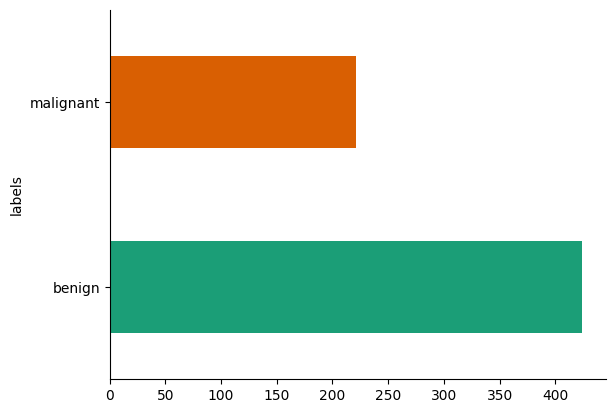

In [ ]:
class_counts = train_df['labels'].value_counts()
print(class_counts)
train_df.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

- EDA Finding: Significant Class Imbalance

The plot clearly shows a severe class imbalance. The 'benign' class has far more samples than the 'malignant' class.

Why this is a problem: A model trained on this data would become "lazy" and biased. It could achieve high accuracy by simply guessing 'benign' most of the time. This would make it useless in a clinical setting, as it would miss most of the malignant (cancerous) cases.

Our Strategy: We will use oversampling on the minority class ('malignant'). We will create new, augmented versions of the malignant images and add them to the training set to create a balanced dataset.

# 5. Data Preprocessing (Part 1): Balancing the Training Set
We will now implement our oversampling strategy using Albumentations to generate new training samples.

Final class distribution in balanced train set:
labels
malignant    442
benign       424
Name: count, dtype: int64


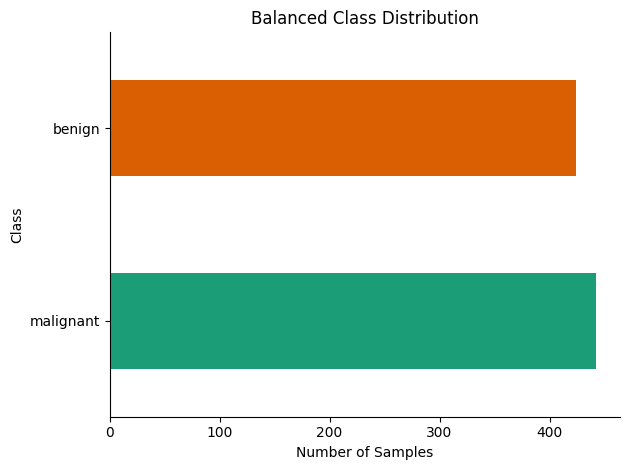

In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)
NUM_CLASSES = len(train_df['labels'].unique())

# Step 1: Filter the malignant samples from the training DataFrame
malignant_df = train_df[train_df['labels'] == 'malignant']

# Step 2: Albumentations transform for augmenting malignant data
augment_transform = Compose([
    Affine(scale=(0.8, 1.2), translate_percent=(0.2, 0.2), rotate=(-40, 40), p=0.1),
    # HorizontalFlip(p=0.1),
    # VerticalFlip(p=0.1),
    RandomRotate90(p=0.5),
    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    # HueSaturationValue(p=0.5),
    # RandomCrop(width=164, height=164, p=0.5),
    Resize(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    ToTensorV2()
])

# Step 3: Basic transform (no augmentation) for the original dataset
basic_transform = Compose([
    Resize(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    ToTensorV2()
])

# Step 4: Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'filepaths']
        label = self.dataframe.loc[idx, 'labels']
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        label_tensor = torch.tensor(int(label == 'malignant'), dtype=torch.long)
        return image, label_tensor

# Step 5: Create augmented malignant dataset
malignant_dataset = CustomDataset(malignant_df, transform=augment_transform)
malignant_loader = DataLoader(malignant_dataset, batch_size=len(malignant_dataset), shuffle=False)

# Step 6: Generate augmented samples
augmented_images, augmented_labels = next(iter(malignant_loader))

# Step 7: Create new DataFrame for augmented samples
augmented_df = pd.DataFrame({
    'filepaths': malignant_df['filepaths'].values,  # Placeholder paths
    'labels': ['malignant'] * len(augmented_images)
})

# Step 8: Combine original and augmented data into a balanced DataFrame
balanced_train_df = pd.concat([train_df, augmented_df], ignore_index=True)

# Step 9: Visualize the final class distribution
print("Final class distribution in balanced train set:")
print(balanced_train_df['labels'].value_counts())

# Optional: Plot
balanced_train_df['labels'].value_counts().plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel("Number of Samples")
plt.ylabel("Class")
plt.title("Balanced Class Distribution")
plt.tight_layout()
plt.show()


The classes are now perfectly balanced. Let's look at a few of the newly created malignant samples to see what our augment_transform did.

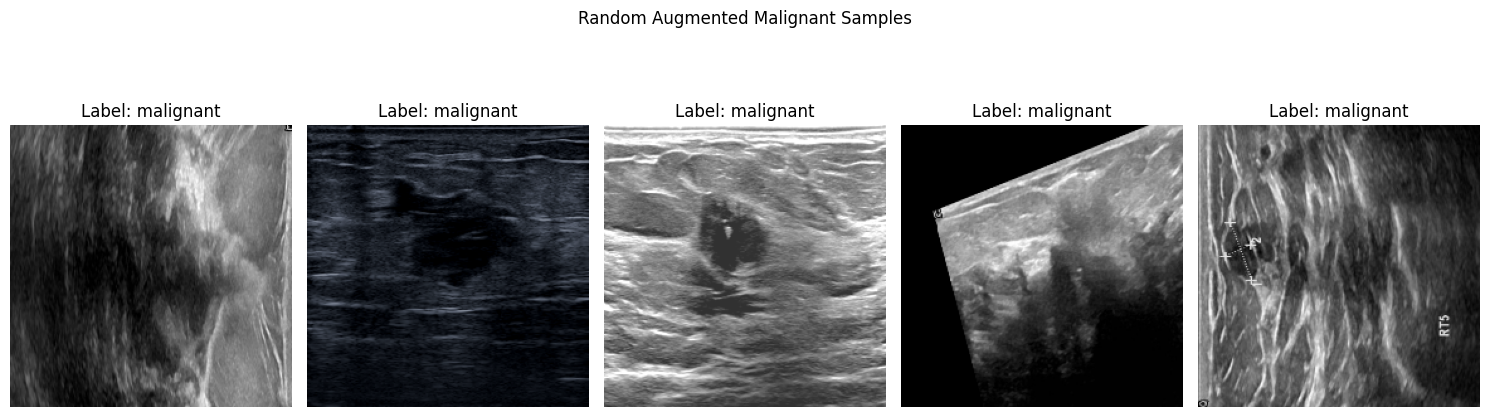

In [ ]:
# Set how many samples you want to visualize
num_samples = 5

# Randomly pick indices from the dataset
random_indices = random.sample(range(len(malignant_dataset)), num_samples)

# Plot the augmented images
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    image_tensor, label = malignant_dataset[idx]
    image_np = image_tensor.permute(1, 2, 0).numpy()  # CHW -> HWC
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(image_np)
    plt.title(f"Label: {'malignant' if label.item() == 1 else 'benign'}")
    plt.axis('off')
plt.suptitle("Random Augmented Malignant Samples")
plt.tight_layout()
plt.show()


# 6. Data Preprocessing : Normalization & Final DataLoaders datasets.

In [ ]:
# Step 1: Create DataLoader for balanced_train_df with basic transform (no augmentation)
balanced_dataset = CustomDataset(train_df, transform=basic_transform)
balanced_loader = DataLoader(balanced_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Step 2: Initialize variables to accumulate pixel values
mean = torch.zeros(3)  # For RGB channels
std = torch.zeros(3)
num_batches = 0

# Step 3: Iterate over the dataset to calculate mean and std
for images, _ in balanced_loader:
    # Convert the image to a float tensor and normalize by 255 (since OpenCV reads as 0-255 range)
    images = images.float() / 255.0
    mean += images.mean([0, 2, 3])  # Mean over batches, height, and width
    std += images.std([0, 2, 3])    # Std over batches, height, and width
    num_batches += 1

# Step 4: Calculate final mean and std
mean /= num_batches
std /= num_batches

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

Mean: tensor([0.3103, 0.3119, 0.3145])
Standard Deviation: tensor([0.2040, 0.2047, 0.2061])


In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)

# Albumentations transforms
train_transform = Compose([
    Resize(*IMAGE_SIZE),
    HorizontalFlip(p=0.1),
    VerticalFlip(p=0.1),
    RandomRotate90(p=0.1),
    CLAHE(),
    GaussNoise(p=0.5),
    Normalize(mean, std),
    ToTensorV2()
])

val_test_transform = Compose([
    Resize(*IMAGE_SIZE),
    Normalize(mean, std),
    ToTensorV2()
])

In [ ]:
# Create datasets
train_dataset = CustomDataset(balanced_train_df, transform=train_transform)
val_dataset = CustomDataset(val_df, transform=val_test_transform)
test_dataset = CustomDataset(test_df, transform=val_test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Let's visualize one last batch from the train_loader to confirm our augmentations and normalization are working.

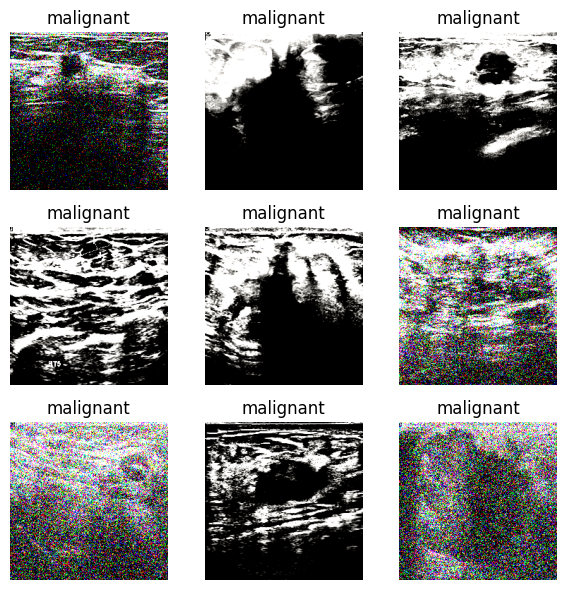

In [ ]:

# Get a batch of images and labels from the DataLoader
sample_images, sample_labels = next(iter(train_loader))

# Convert the images from tensor to numpy for display
sample_images = sample_images.permute(0, 2, 3, 1).numpy()  # Change from [batch, channels, height, width] to [batch, height, width, channels]

# Plotting
plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])

    # Get label name (assuming labels are already integer-encoded)
    label = 'malignant' if sample_labels[i] == 1 else 'benign'

    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

# 7. Model 1: Fine-Tuning ResNet50
We will use transfer learning with a ResNet50 model pre-trained on ImageNet. Instead of training a model from scratch (which requires huge amounts of data), we leverage the features ResNet has already learned.

## ResNet50 - Architecture
Our fine-tuning strategy:

1. Freeze all layers to start.

2. Unfreeze the last 50 residual blocks. This allows the model to adjust its more complex feature detectors to our specific ultrasound data.

3. Replace the final fc (fully-connected) layer with a custom ClassifierHead. Our custom head includes BatchNorm and Dropout for better regularization, which helps prevent overfitting.

In [ ]:
# Step 1: Load pretrained ResNet model
model = timm.create_model('resnet50', pretrained=True)

# Step 2: Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Step 3: Unfreeze the last 50 residual blocks
residual_blocks = []
for name in ['layer1', 'layer2', 'layer3', 'layer4']:
    layer = getattr(model, name)
    for block in layer:
        residual_blocks.append(block)

# Unfreeze last 50 blocks
for block in residual_blocks[-50:]:
    for param in block.parameters():
        param.requires_grad = True

trainable = sum(p.requires_grad for p in model.parameters())
total = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable}/{total} ({100 * trainable / total:.2f}%)")

# Step 4: Replace the classifier with a more complex custom head
class ClassifierHead(nn.Module):
    def __init__(self, in_features, num_classes):
        super(ClassifierHead, self).__init__()
        self.head = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.head(x)

# Replace ResNet's final layer
NUM_CLASSES = 2
model.fc = ClassifierHead(model.fc.in_features, NUM_CLASSES)


print(model)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Trainable parameters: 156/25557032 (0.00%)
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, a

## ResNet50 - Training Configuration
We define our helper class and training components:

- EarlyStopping: A class to monitor the validation loss and stop the training if it doesn't improve for a set number of patience epochs. It also restores the best model weights.

- optimizer: We use Adam, a popular and effective optimizer.

- criterion: CrossEntropyLoss is the standard for multi-class (or binary) classification.

- scheduler: ReduceLROnPlateau will automatically decrease the learning rate if the validation loss stagnates.

Epoch [1/40], Train Loss: 0.7042, Train Acc: 56.93%, Val Loss: 0.6630, Val Acc: 66.87%
Epoch [2/40], Train Loss: 0.6816, Train Acc: 61.32%, Val Loss: 0.6025, Val Acc: 68.10%
Epoch [3/40], Train Loss: 0.6201, Train Acc: 67.55%, Val Loss: 0.5426, Val Acc: 76.07%
Epoch [4/40], Train Loss: 0.5821, Train Acc: 66.74%, Val Loss: 0.5368, Val Acc: 75.46%
Epoch [5/40], Train Loss: 0.5144, Train Acc: 74.48%, Val Loss: 0.5366, Val Acc: 76.07%
Epoch [6/40], Train Loss: 0.4870, Train Acc: 75.87%, Val Loss: 0.4950, Val Acc: 76.07%
Epoch [7/40], Train Loss: 0.4609, Train Acc: 81.06%, Val Loss: 0.5809, Val Acc: 75.46%
Epoch [8/40], Train Loss: 0.4320, Train Acc: 79.33%, Val Loss: 0.3791, Val Acc: 84.66%
Epoch [9/40], Train Loss: 0.3963, Train Acc: 80.72%, Val Loss: 0.4122, Val Acc: 82.82%
Epoch [10/40], Train Loss: 0.3992, Train Acc: 82.10%, Val Loss: 0.4819, Val Acc: 82.82%
Epoch [11/40], Train Loss: 0.3804, Train Acc: 82.56%, Val Loss: 0.4017, Val Acc: 84.66%
Epoch [12/40], Train Loss: 0.3737, Train 

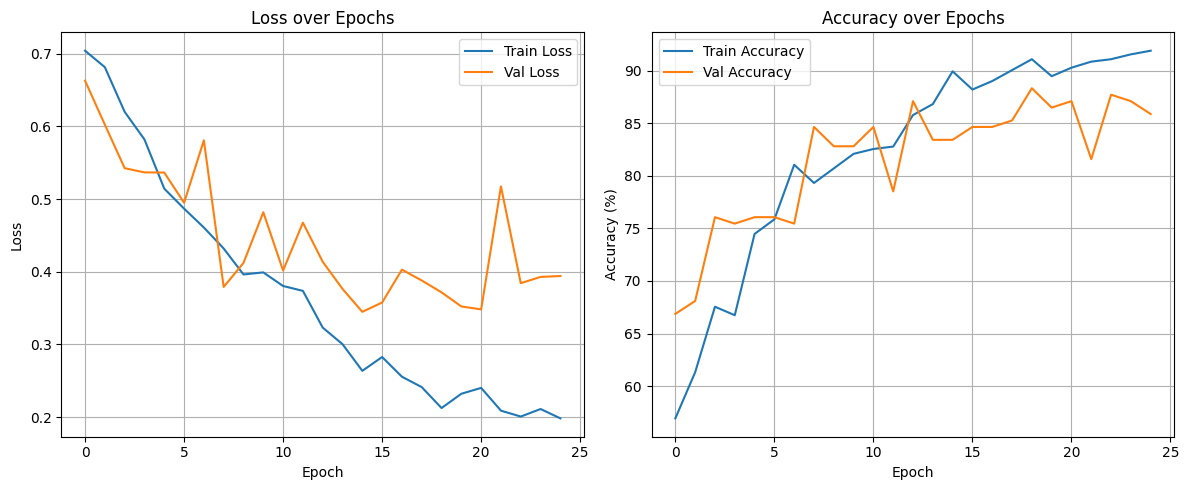

Test Accuracy: 86.81%, Test Loss: 0.3525


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, restore_best_weights=True):
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best_loss = float('inf')
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_weights = model.state_dict()
        else:
            self.counter += 1
        if self.counter >= self.patience:
            print(f'Early stopping triggered after {self.patience} epochs.')
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

# Learning Rate Scheduler
def adjust_lr(optimizer, epoch, lr_scheduler):
    lr_scheduler.step(epoch)

# Optimizer and Loss Function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Scheduler for learning rate reduction
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=3, min_lr=1e-6)

# EarlyStopping object
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Training loop
epochs = 40
best_val_loss = float('inf')
model = model.to(device)

# Tracking metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print Epoch Statistics
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    scheduler.step(val_loss)

    if early_stopping(val_loss, model):
        print(f"Stopping early at epoch {epoch+1}")
        break

# Save the best model
torch.save(model.state_dict(), 'best_model.pth')

# Plot Loss and Accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Test Phase
model.eval()
test_correct = 0
test_total = 0
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += targets.size(0)
        test_correct += (predicted == targets).sum().item()

test_loss = test_loss / len(test_loader)
test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%, Test Loss: {test_loss:.4f}')

Now, we evaluate the model on the unseen test set. Accuracy isn't the whole story, so we will calculate F1-Score, Precision, and Recall.

- Recall (Sensitivity): Of all the actual malignant cases, how many did we find? (True Positives / (True Positives + False Negatives)). This is the most important metric in medicine. A False Negative (missing a cancer) is the worst possible outcome.

- Precision: Of all the cases we predicted as malignant, how many were correct? (True Positives / (True Positives + False Positives)).

- F1-Score: The harmonic mean of Precision and Recall.

F1 Score: 0.8000
Recall: 0.7742
Precision: 0.8276


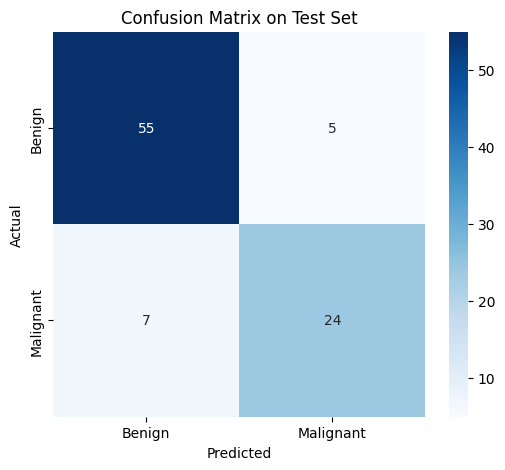

In [ ]:

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Metrics
f1 = f1_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
precision = precision_score(all_labels, all_preds, average='binary')

print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

# Display Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

## ResNet50 - Prediction Visualization
Let's look at some individual predictions from the test set. (Green = Correct, Red = Incorrect).

In [ ]:
def display_predictions(model, dataloader, class_names, device, num_samples=12):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(12, 12))

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_samples:
                    break
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = np.clip(img, 0, 1)

                ax = plt.subplot((num_samples + 3) // 4, 4, images_shown + 1)
                ax.imshow(img)
                ax.axis('off')
                pred_label = class_names[preds[i]]
                true_label = class_names[labels[i]]
                color = 'green' if pred_label == true_label else 'red'
                ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
                images_shown += 1

            if images_shown >= num_samples:
                break

    plt.tight_layout()
    plt.show()


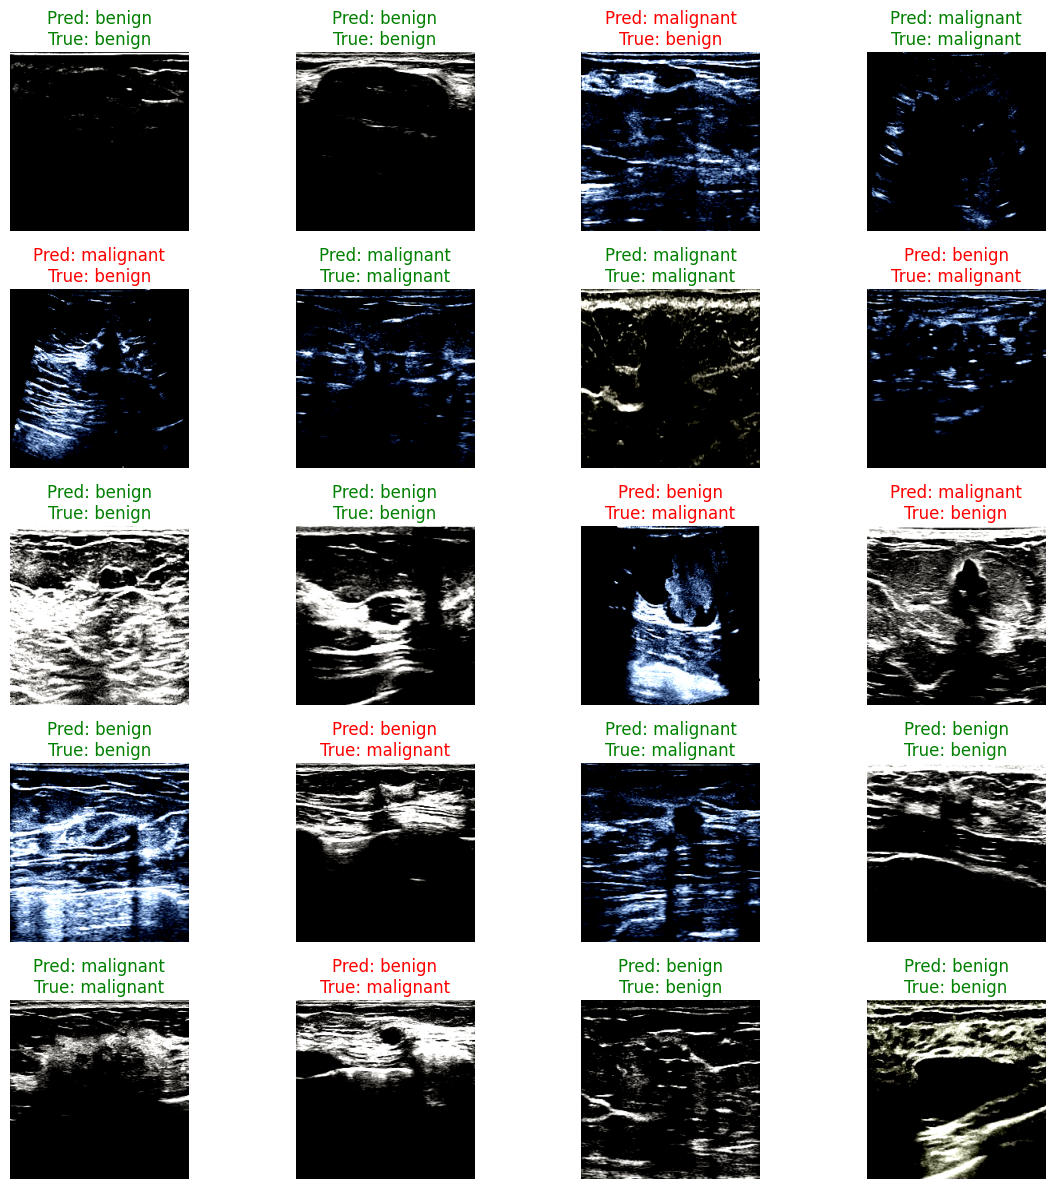

In [ ]:
class_names = ['benign', 'malignant']  # Adjust based on your dataset
display_predictions(model, test_loader, class_names, device, num_samples=20)

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/cancer_proj/resnet_model2.pth')


# 8.  Model 2: Fine-Tuning Inception V3
Let's run a second experiment using a different architecture, Inception V3, to see if we can improve our results. The process is very similar.

## Inception V3 - Architecture & Training

In [ ]:
# Step 1: Load the pre-trained Inception v3 model
model = timm.create_model('inception_v3', pretrained=True)

# Step 2: Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Step 3: Unfreeze the last few blocks
num_layers_to_unfreeze = 50
all_params = list(model.parameters())
for param in all_params[-num_layers_to_unfreeze:]:
    param.requires_grad = True

# Step 4: Modify the final classification layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)   

model = nn.Sequential(
    model,
    nn.BatchNorm1d(NUM_CLASSES),
    nn.Dropout(0.5)
)

# Step 5: Optimizer and Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print(model)


model.safetensors:   0%|          | 0.00/95.5M [00:00<?, ?B/s]

Sequential(
  (0): InceptionV3(
    (Conv2d_1a_3x3): ConvNormAct(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNormAct2d(
        32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (Conv2d_2a_3x3): ConvNormAct(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (Conv2d_2b_3x3): ConvNormAct(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (Pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
 

## Inception V3 - Training Configuration

Epoch [1/40], Train Loss: 0.8044, Train Acc: 59.24%, Val Loss: 0.8647, Val Acc: 73.01%
Epoch [2/40], Train Loss: 0.6626, Train Acc: 63.16%, Val Loss: 0.8212, Val Acc: 73.01%
Epoch [3/40], Train Loss: 0.5764, Train Acc: 66.17%, Val Loss: 0.5645, Val Acc: 69.33%
Epoch [4/40], Train Loss: 0.5238, Train Acc: 70.44%, Val Loss: 0.4459, Val Acc: 76.69%
Epoch [5/40], Train Loss: 0.5033, Train Acc: 71.25%, Val Loss: 0.4440, Val Acc: 79.75%
Epoch [6/40], Train Loss: 0.4878, Train Acc: 73.44%, Val Loss: 0.4732, Val Acc: 76.69%
Epoch [7/40], Train Loss: 0.5092, Train Acc: 69.52%, Val Loss: 0.5431, Val Acc: 77.30%
Epoch [8/40], Train Loss: 0.4943, Train Acc: 71.36%, Val Loss: 0.5334, Val Acc: 74.23%
Epoch [9/40], Train Loss: 0.4743, Train Acc: 74.25%, Val Loss: 0.4612, Val Acc: 78.53%
Epoch [10/40], Train Loss: 0.4529, Train Acc: 75.40%, Val Loss: 0.4978, Val Acc: 74.85%
Epoch [11/40], Train Loss: 0.4522, Train Acc: 75.17%, Val Loss: 0.4427, Val Acc: 77.30%
Epoch [12/40], Train Loss: 0.4691, Train 

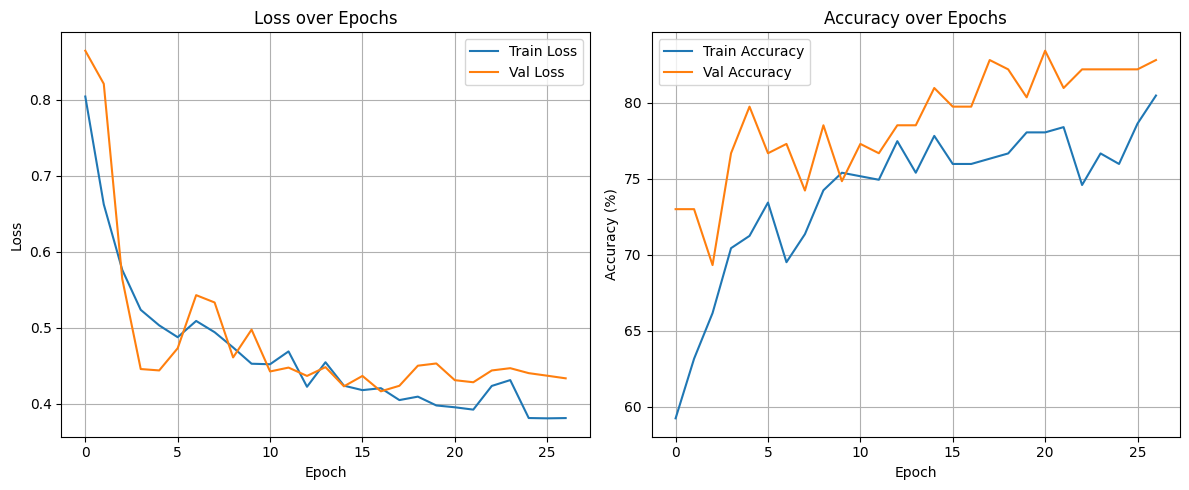

Test Accuracy: 83.52%, Test Loss: 0.3697


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, restore_best_weights=True):
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best_loss = float('inf')
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_weights = model.state_dict()
        else:
            self.counter += 1
        if self.counter >= self.patience:
            print(f'Early stopping triggered after {self.patience} epochs.')
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

# Learning Rate Scheduler
def adjust_lr(optimizer, epoch, lr_scheduler):
    lr_scheduler.step(epoch)

# Optimizer and Loss Function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Scheduler for learning rate reduction
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=3, min_lr=1e-6)

# EarlyStopping object
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Training loop
epochs = 40
best_val_loss = float('inf')
model = model.to(device)

# Tracking metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print Epoch Statistics
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    scheduler.step(val_loss)

    if early_stopping(val_loss, model):
        print(f"Stopping early at epoch {epoch+1}")
        break

# Save the best model
torch.save(model.state_dict(), 'best_model.pth')

# Plot Loss and Accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Test Phase
model.eval()
test_correct = 0
test_total = 0
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += targets.size(0)
        test_correct += (predicted == targets).sum().item()

test_loss = test_loss / len(test_loader)
test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%, Test Loss: {test_loss:.4f}')

## Inception V3 - Evaluation
Let's evaluate our Inception V3 model.

F1 Score: 0.7692
Recall: 0.8065
Precision: 0.7353


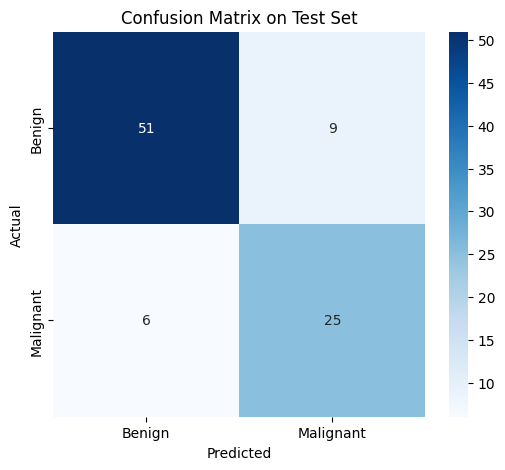

In [ ]:

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Metrics
f1 = f1_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
precision = precision_score(all_labels, all_preds, average='binary')

print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

# Display Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

## Inception V3 - Prediction Visualization

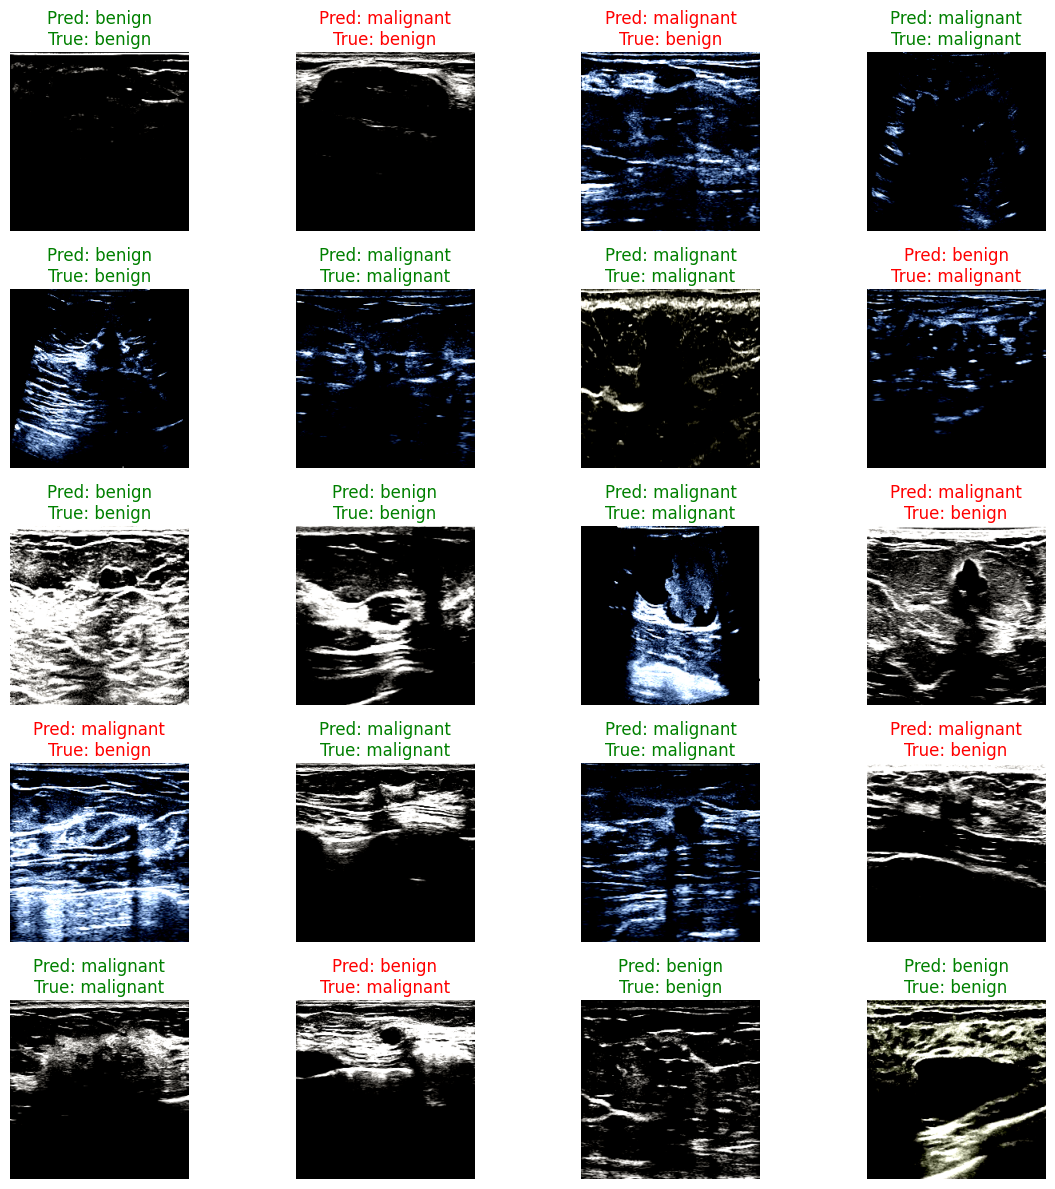

In [ ]:
class_names = ['benign', 'malignant']  # Adjust based on your dataset
display_predictions(model, test_loader, class_names, device, num_samples=20)

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/cancer_proj/inception_v3_model2.pth')
